<a href="https://colab.research.google.com/github/NawinMasterM/Superai_Lv1_ImageProcessing/blob/main/Digit_Recognizer_99.28%25%20accuracy_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer
https://www.kaggle.com/competitions/digit-recognizer/data

## Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install albumentations -qq

!pip install matplotlib==3.1.3 -qq

!pip install --upgrade gdown -qq

!pip install split-folders[full] -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.2 MB/s eta 0:00:00


In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import shutil

#augmentation
import albumentations as A

#image
import cv2
import imutils #rotate image
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps

from skimage.morphology import skeletonize 
from skimage.util import invert

#plot
import matplotlib.pyplot as plt
import seaborn as sns

#spli folder
import splitfolders

#Model
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.optimizers import RMSprop, SGD

from tensorflow.keras.applications import VGG16, MobileNetV2

## Load Data

In [2]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                             title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                   480KB  2023-01-04 12:50:31           3669        133  1.0              
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022              621KB  2023-01-02 20:10:36           1831         62  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset              Fifa World Cup 2022: Complete Dataset          7KB  2022-12-18 22:51:11           6729        205  1.0              
rakkesharv/spotify-top-10000-streamed-songs                     Spotify Top 10000 Streamed Song

In [5]:
!kaggle competitions download -c digit-recognizer

 91% 14.0M/15.3M [00:01<00:00, 20.0MB/s]
100% 15.3M/15.3M [00:01<00:00, 15.9MB/s]


In [6]:
!unzip -q /content/digit-recognizer.zip

## Read Data

In [7]:
#train
df_train = pd.read_csv('/content/train.csv')

#test
df_test = pd.read_csv('/content/test.csv')

#sub
sub = pd.read_csv('/content/sample_submission.csv')

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

### Change table to image

In [9]:
!mkdir train
!mkdir test

for i in range(10):
  os.makedirs(f'train/{i}', exist_ok=True)

Result

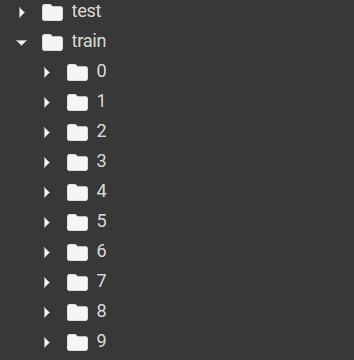

**Train**

In [10]:
for index, row in tqdm(df_train.iterrows()):
  label, digit = row[0], row[1:]

  #change array 784 to 28*28
  digit = digit.values
  digit = digit.reshape(28, 28)
  digit = digit.astype(np.uint8)

  #convert array to img
  img = Image.fromarray(digit)

  #path to save img
  img_path = f'train/{label}/{index}.png'

  #save img
  img.save(img_path)

42000it [00:17, 2440.83it/s]


Result

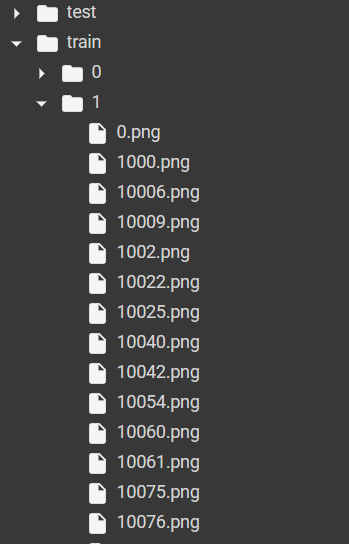

**Test**

In [11]:
for index, row in tqdm(df_test.iterrows()):
  digit = row

  #change array 784 to 28*28
  digit = digit.values
  digit = digit.reshape(28, 28)
  digit = digit.astype(np.uint8)

  #convert array to img
  img = Image.fromarray(digit)

  #path to save img
  img_path = f'test/{index+1}.png'

  #save img
  img.save(img_path)

28000it [00:09, 3006.99it/s]


Result

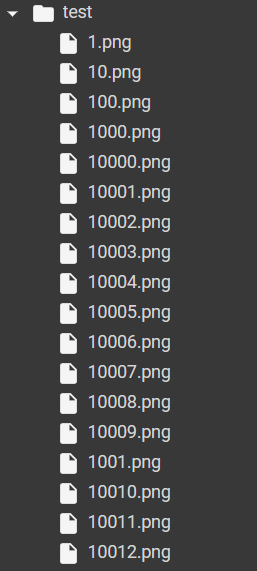

In [12]:
for index, row in tqdm(sub.iterrows()):
  img_path = f'test/{index+1}.png'
  sub.loc[index, 'file_name'] = img_path
sub

28000it [00:23, 1206.49it/s]


,ImageId,Label,file_name
0,1,0,test/1.png
1,2,0,test/2.png
2,3,0,test/3.png
3,4,0,test/4.png
4,5,0,test/5.png
...,...,...,...
27995,27996,0,test/27996.png
27996,27997,0,test/27997.png
27997,27998,0,test/27998.png
27998,27999,0,test/27999.png


## Preprocessing
- resize (INTER_LANCZOS4)
- Dilation
- Crop
- Erose
- skeleton

Example

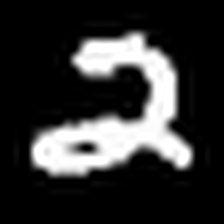

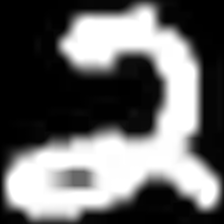

In [13]:
img = cv2.imread('/content/test/1.png')
kernel = np.ones((5, 5), np.uint8)
#resize
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
cv2_imshow(img)

img = cv2.dilate(img, kernel, iterations=2)

#crop
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray.copy(), 150, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=lambda x: cv2.contourArea(x))
x, y, w, h = cv2.boundingRect(cnt)
img = cv2.erode(img, kernel, iterations=2)
img = img[y:y+h, x:x+w].copy()
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
cv2_imshow(img)

In [14]:
base = '/content/train'
for i in tqdm(os.listdir(base)):
  dir = os.path.join(base, i)
  lis = os.listdir(dir)
  for j in lis:

    img_path = os.path.join(dir, j)
    img = cv2.imread(img_path)

    #resize
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
    
    #dilate
    img = cv2.dilate(img, kernel, iterations=2)

    #crop
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray.copy(), 150, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=lambda x: cv2.contourArea(x))
    x, y, w, h = cv2.boundingRect(cnt)
    img = cv2.erode(img, kernel, iterations=2)
    img = img[y:y+h, x:x+w].copy()
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)

    cv2.imwrite(img_path, img)

100%|██████████| 10/10 [03:23<00:00, 20.32s/it]


In [15]:
base = '/content/test'
kernel = np.ones((5, 5), np.uint8)
lis = os.listdir(base)
for i in tqdm(lis):
  img_path = os.path.join(base, i)
  img = cv2.imread(img_path)

  #resize
  img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
  
  #dilate
  img = cv2.dilate(img, kernel, iterations=2)

  #crop
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray.copy(), 150, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(contours, key=lambda x: cv2.contourArea(x))
  x, y, w, h = cv2.boundingRect(cnt)
  img = cv2.erode(img, kernel, iterations=2)
  img = img[y:y+h, x:x+w].copy()
  img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)

  cv2.imwrite(img_path, img)

100%|██████████| 28000/28000 [02:23<00:00, 194.52it/s]


## Augmentation

In [2]:
!rm -rf train_val
splitfolders.ratio("/content/train", output="train_val", seed=1337, ratio=(.90, .10), group_prefix=None, move=False)

Copying files: 42000 files [00:10, 4161.59 files/s]


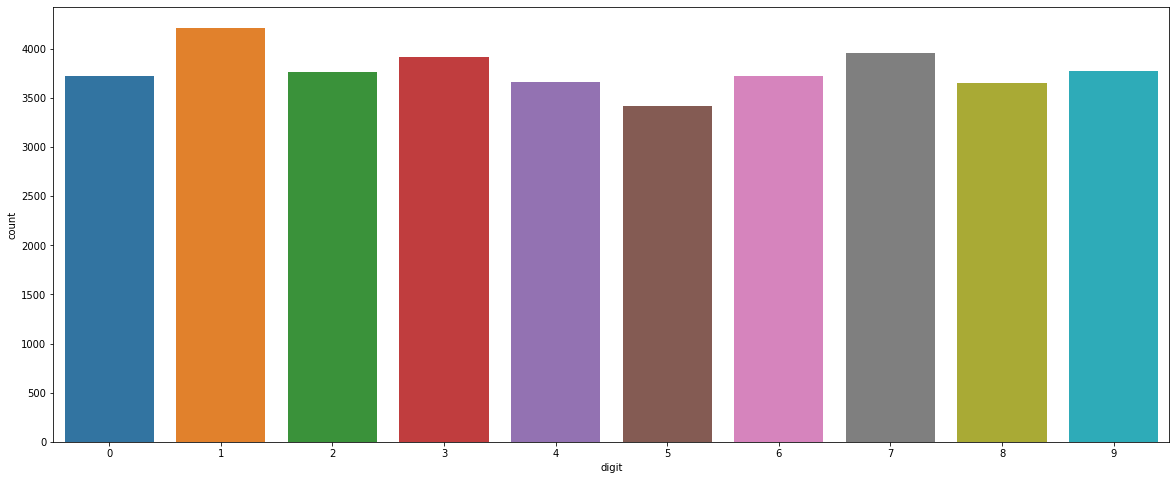

In [3]:
digit, count = [], []
for i in os.listdir('/content/train_val/train'):
  digit.append(i)
  count.append(len(os.listdir('/content/train_val/train/'+i)))

df = pd.DataFrame({
    'digit':digit,
    'count':count
})
df.sort_values(by='digit', inplace=True)
plt.figure(figsize=(20, 8));
sns.barplot(data=df,x='digit', y='count');

In [4]:
transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=20),
])

base = '/content/train_val/train'
for i in tqdm(os.listdir(base)):
  dir = os.path.join(base, i)
  lis = os.listdir(dir)
  for j in lis:

    if len(os.listdir(dir)) < 8000:
      img_path = os.path.join(dir, j)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      for i in range(5):
        path_new = img_path[:-4] + f'_rotate_{i}.png'
        transformed = transform(image=img)['image']
        while ((img == transformed).all()):
          transformed = transform(image=img)['image']
        transformed = cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR)

        #crop
        gray = cv2.cvtColor(transformed, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray.copy(), 150, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=lambda x: cv2.contourArea(x))
        x, y, w, h = cv2.boundingRect(cnt)
        transformed = transformed[y:y+h, x:x+w].copy()
        transformed = cv2.resize(transformed, (224, 224), interpolation=cv2.INTER_LANCZOS4)
        cv2.imwrite(path_new, transformed)
    else:
      break

100%|██████████| 10/10 [03:54<00:00, 23.48s/it]


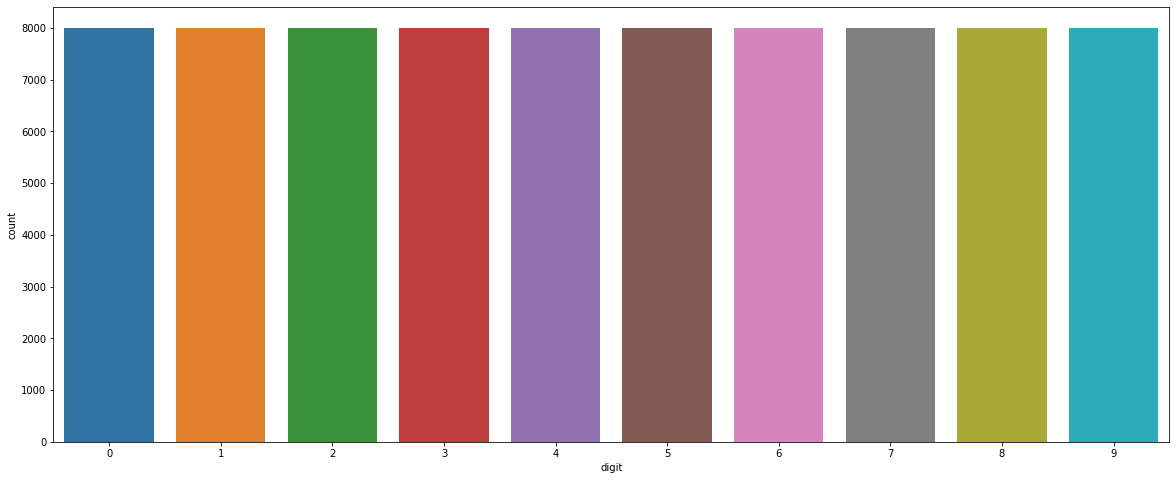

In [5]:
digit, count = [], []
for i in os.listdir('/content/train_val/train'):
  digit.append(i)
  count.append(len(os.listdir('/content/train_val/train/'+i)))

df = pd.DataFrame({
    'digit':digit,
    'count':count
})
df.sort_values(by='digit', inplace=True)
plt.figure(figsize=(20, 8));
sns.barplot(data=df,x='digit', y='count');

## Save all file to drive

In [ ]:
#train
!zip -r -q '/content/drive/MyDrive/Colab Notebooks/SuperAi/Pracetice/Digit Recognizer Kaggle/train_val2.zip' /content/train_val

#test
!zip -r -q '/content/drive/MyDrive/Colab Notebooks/SuperAi/Pracetice/Digit Recognizer Kaggle/test2.zip' /content/test

#sub data frame
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/SuperAi/Pracetice/Digit Recognizer Kaggle/sub.csv', index=False)

## Load all file from drive

In [ ]:
#train_val
!gdown 1--xBUOrax02XfaJOOXy-PXQHhdFTCjQn

#test
!gdown 1-4eH8ez48csq_bzl0fNG3pyOcbhM1hE2

#sub
!gdown 1-2Gr35r_Xpa92ypR439PxADOnqjazOCw

Downloading...
From: https://drive.google.com/uc?id=1KldJyxL4H2gbrX6bl6RfBLasv2sYlhUR
To: /content/train_val.zip
100% 1.11G/1.11G [00:11<00:00, 96.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0-0FmtjKSGu-S3kArH-LatB7yLeA8TH
To: /content/test.zip
100% 352M/352M [00:03<00:00, 88.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2Gr35r_Xpa92ypR439PxADOnqjazOCw
To: /content/sub.csv
100% 622k/622k [00:00<00:00, 162MB/s]


In [ ]:
!unzip -q /content/train_val.zip
!unzip -q /content/test.zip

In [ ]:
#move file

source_dir = '/content/content'
target_dir = '/content/'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

!rm -rf '/content/content'

In [ ]:
sub = pd.read_csv('/content/sub.csv')
sub.head()

,ImageId,Label,file_name
0,1,0,test/1.png
1,2,0,test/2.png
2,3,0,test/3.png
3,4,0,test/4.png
4,5,0,test/5.png


In [ ]:
os.rename('train_val2', 'train_val')
os.rename('test', 'test')

## Model

### VGG16 99.46%

#### VGG16 95% accuracy

**Data**

In [ ]:
base_dir = 'train_val'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
# train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = False)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Train Flow training images in batches of 60 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 60, class_mode = 'sparse', target_size = (224, 224))

# Validation Flow validation images in batches of 60 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 60, class_mode = 'sparse', target_size = (224, 224), shuffle=False)

# Test use flow from dataframe เพราะ เวลาส่งชื่อต้องเรียงตาม format เขา
test_generator = test_datagen.flow_from_dataframe(sub, x_col='file_name', batch_size = 60, class_mode = None , target_size = (224, 224), shuffle=False)
# test_generator = test_datagen.flow_from_dataframe(sub, x_col='file_name', y_col='ans' ,batch_size = 60, class_mode = 'sparse' , target_size = (224, 224), shuffle=False)

Found 80019 images belonging to 10 classes.
Found 4206 images belonging to 10 classes.
Found 28000 validated image filenames.


**Model**

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# Freeze the base model
base_model.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='LeakyReLU')(x)
x = layers.Dropout(0.4)(x)

# Add a final sigmoid layer with ... node for classification output
x = layers.Dense(10, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

#อย่าลืมเปลี่ยน loss ให้เหมาะกับงาน แต่คิดว่าแค่ตัวนี้ก็เพียงพอ
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#เอาไว้เก็บ best_model
!rm -rf 'vgg16_best'

checkpoint = ModelCheckpoint("vgg16_best", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='max') #2 ตัวไม่ดีขึ้นก็หยุด
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 1000, callbacks=[checkpoint,early])

Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.8964 - acc: 0.7220
Epoch 1: val_acc improved from -inf to 0.93890, saving model to vgg16_best


100/100 [==============================] - 67s 543ms/step - loss: 0.8964 - acc: 0.7220 - val_loss: 0.2310 - val_acc: 0.9389
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.2831 - acc: 0.9118
Epoch 2: val_acc improved from 0.93890 to 0.95887, saving model to vgg16_best


100/100 [==============================] - 55s 551ms/step - loss: 0.2831 - acc: 0.9118 - val_loss: 0.1351 - val_acc: 0.9589
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.2223 - acc: 0.9317
Epoch 3: val_acc did not improve from 0.95887
100/100 [==============================] - 52s 516ms/step - loss: 0.2223 - acc: 0.9317 - val_loss: 0.1535 - val_acc: 0.9503
Epoch 4/1000
100/100 [==============================] - ETA: 0s - loss: 0.1679 - acc: 0.9493
Epoch 4: val_acc improved from 0.95887 to 0.96671, saving model to vgg16_best


100/100 [==============================] - 55s 551ms/step - loss: 0.1679 - acc: 0.9493 - val_loss: 0.1008 - val_acc: 0.9667
Epoch 5/1000
100/100 [==============================] - ETA: 0s - loss: 0.1754 - acc: 0.9448
Epoch 5: val_acc did not improve from 0.96671
100/100 [==============================] - 51s 515ms/step - loss: 0.1754 - acc: 0.9448 - val_loss: 0.1283 - val_acc: 0.9610
Epoch 6/1000
100/100 [==============================] - ETA: 0s - loss: 0.1470 - acc: 0.9537
Epoch 6: val_acc improved from 0.96671 to 0.97385, saving model to vgg16_best


100/100 [==============================] - 55s 552ms/step - loss: 0.1470 - acc: 0.9537 - val_loss: 0.0887 - val_acc: 0.9738
Epoch 7/1000
100/100 [==============================] - ETA: 0s - loss: 0.1600 - acc: 0.9527
Epoch 7: val_acc improved from 0.97385 to 0.97622, saving model to vgg16_best


100/100 [==============================] - 55s 551ms/step - loss: 0.1600 - acc: 0.9527 - val_loss: 0.0794 - val_acc: 0.9762
Epoch 8/1000
100/100 [==============================] - ETA: 0s - loss: 0.1154 - acc: 0.9628
Epoch 8: val_acc did not improve from 0.97622
100/100 [==============================] - 52s 524ms/step - loss: 0.1154 - acc: 0.9628 - val_loss: 0.1075 - val_acc: 0.9689
Epoch 9/1000
100/100 [==============================] - ETA: 0s - loss: 0.1286 - acc: 0.9605
Epoch 9: val_acc did not improve from 0.97622
100/100 [==============================] - 53s 526ms/step - loss: 0.1286 - acc: 0.9605 - val_loss: 0.0805 - val_acc: 0.9757
Epoch 10/1000
100/100 [==============================] - ETA: 0s - loss: 0.1258 - acc: 0.9610
Epoch 10: val_acc improved from 0.97622 to 0.98027, saving model to vgg16_best


100/100 [==============================] - 55s 552ms/step - loss: 0.1258 - acc: 0.9610 - val_loss: 0.0657 - val_acc: 0.9803


KeyboardInterrupt: ignored

#### Add image that model confuse

71/71 [==============================] - 21s 289ms/step
/content/train_val/train/0/val_91.png


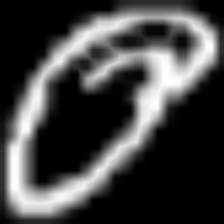

Ai pred: 9

/content/train_val/train/0/val_264.png


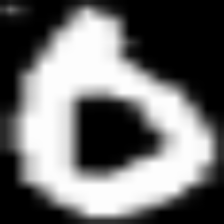

Ai pred: 6

/content/train_val/train/1/val_586.png


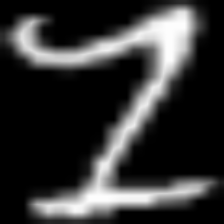

Ai pred: 2

/content/train_val/train/1/val_587.png


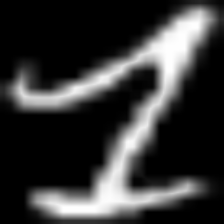

Ai pred: 4

/content/train_val/train/1/val_591.png


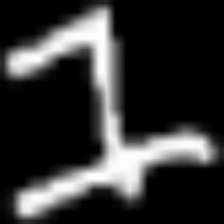

Ai pred: 2

/content/train_val/train/1/val_719.png


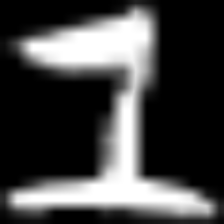

Ai pred: 2

/content/train_val/train/2/val_905.png


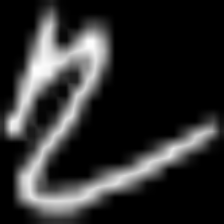

Ai pred: 6

/content/train_val/train/2/val_922.png


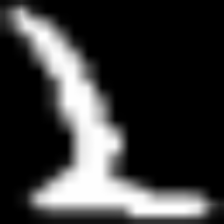

Ai pred: 1

/content/train_val/train/2/val_953.png


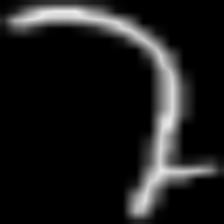

Ai pred: 7

/content/train_val/train/2/val_982.png


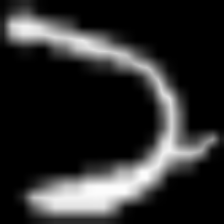

Ai pred: 3

/content/train_val/train/2/val_1133.png


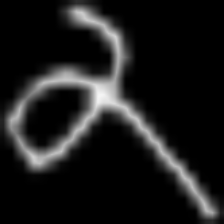

Ai pred: 9

/content/train_val/train/2/val_1245.png


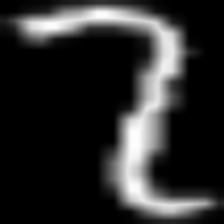

Ai pred: 7

/content/train_val/train/3/val_1380.png


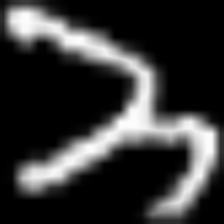

Ai pred: 2

/content/train_val/train/3/val_1401.png


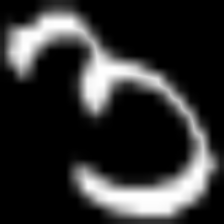

Ai pred: 5

/content/train_val/train/3/val_1410.png


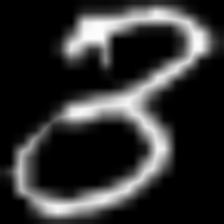

Ai pred: 8

/content/train_val/train/3/val_1425.png


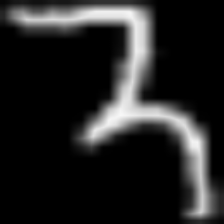

Ai pred: 7

/content/train_val/train/3/val_1478.png


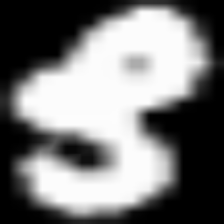

Ai pred: 8

/content/train_val/train/3/val_1493.png


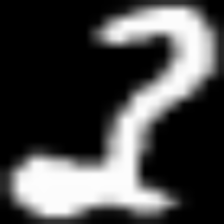

Ai pred: 2

/content/train_val/train/3/val_1582.png


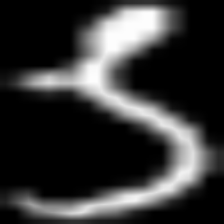

Ai pred: 5

/content/train_val/train/3/val_1642.png


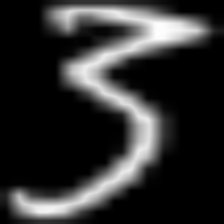

Ai pred: 5

/content/train_val/train/4/val_1778.png


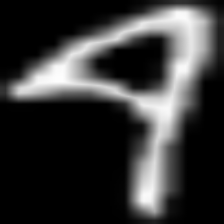

Ai pred: 9

/content/train_val/train/4/val_1855.png


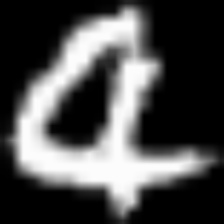

Ai pred: 2

/content/train_val/train/4/val_1872.png


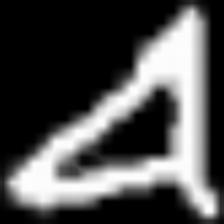

Ai pred: 2

/content/train_val/train/4/val_1930.png


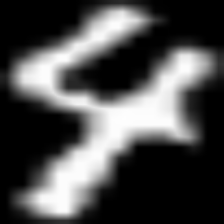

Ai pred: 9

/content/train_val/train/4/val_1933.png


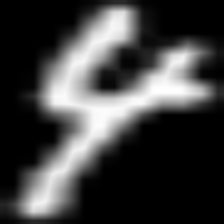

Ai pred: 1

/content/train_val/train/4/val_2040.png


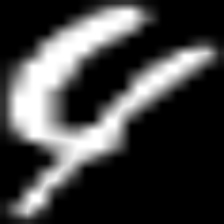

Ai pred: 8

/content/train_val/train/4/val_2090.png


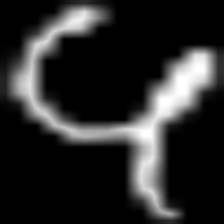

Ai pred: 9

/content/train_val/train/4/val_2144.png


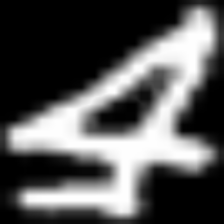

Ai pred: 6

/content/train_val/train/5/val_2149.png


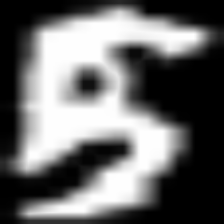

Ai pred: 8

/content/train_val/train/5/val_2172.png


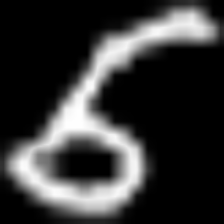

Ai pred: 6

/content/train_val/train/5/val_2344.png


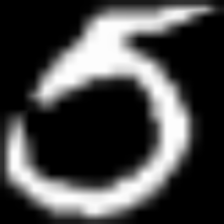

Ai pred: 0

/content/train_val/train/5/val_2404.png


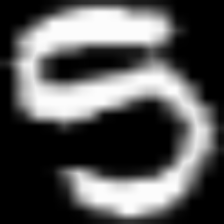

Ai pred: 3

/content/train_val/train/5/val_2414.png


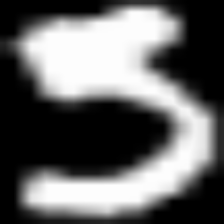

Ai pred: 3

/content/train_val/train/5/val_2423.png


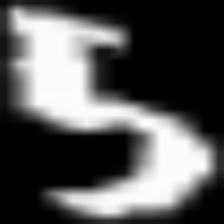

Ai pred: 3

/content/train_val/train/5/val_2425.png


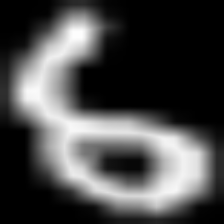

Ai pred: 6

/content/train_val/train/5/val_2475.png


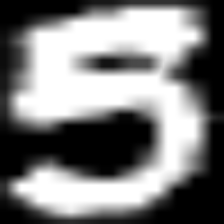

Ai pred: 3

/content/train_val/train/6/val_2530.png


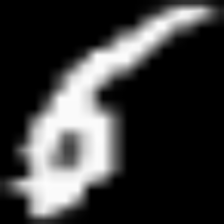

Ai pred: 1

/content/train_val/train/6/val_2553.png


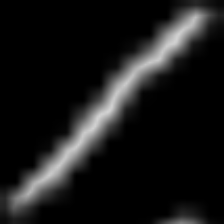

Ai pred: 1

/content/train_val/train/6/val_2559.png


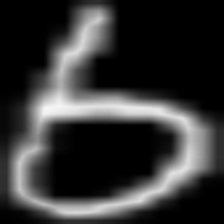

Ai pred: 5

/content/train_val/train/6/val_2561.png


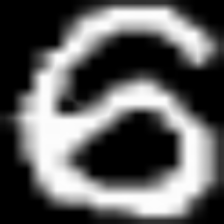

Ai pred: 8

/content/train_val/train/6/val_2634.png


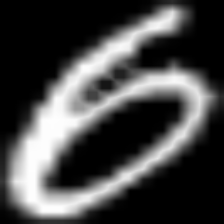

Ai pred: 0

/content/train_val/train/6/val_2642.png


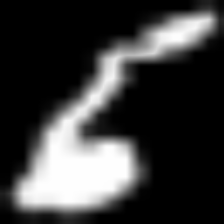

Ai pred: 5

/content/train_val/train/6/val_2730.png


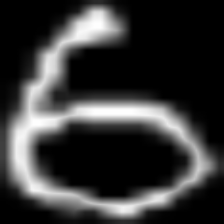

Ai pred: 5

/content/train_val/train/6/val_2808.png


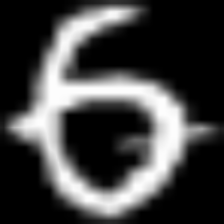

Ai pred: 5

/content/train_val/train/6/val_2827.png


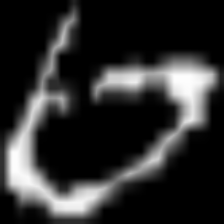

Ai pred: 0

/content/train_val/train/6/val_2879.png


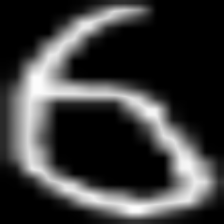

Ai pred: 5

/content/train_val/train/6/val_2920.png


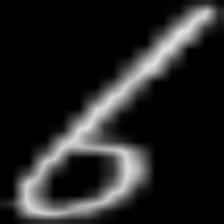

Ai pred: 1

/content/train_val/train/7/val_2976.png


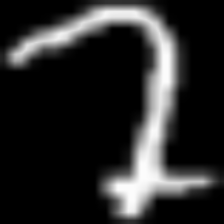

Ai pred: 2

/content/train_val/train/7/val_3048.png


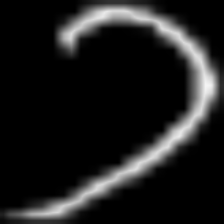

Ai pred: 2

/content/train_val/train/7/val_3080.png


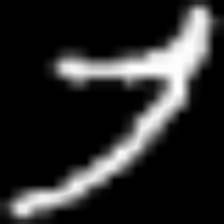

Ai pred: 3

/content/train_val/train/7/val_3113.png


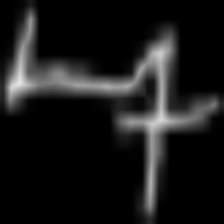

Ai pred: 4

/content/train_val/train/7/val_3180.png


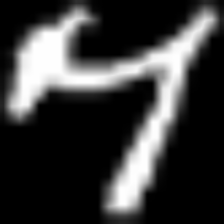

Ai pred: 4

/content/train_val/train/7/val_3311.png


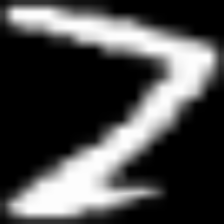

Ai pred: 2

/content/train_val/train/7/val_3326.png


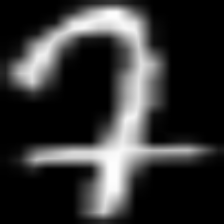

Ai pred: 2

/content/train_val/train/8/val_3398.png


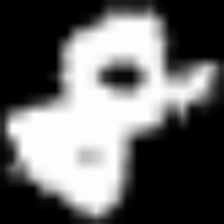

Ai pred: 4

/content/train_val/train/8/val_3404.png


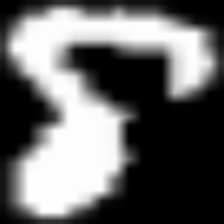

Ai pred: 7

/content/train_val/train/8/val_3431.png


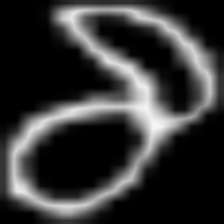

Ai pred: 2

/content/train_val/train/8/val_3456.png


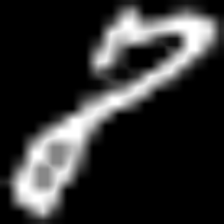

Ai pred: 2

/content/train_val/train/8/val_3488.png


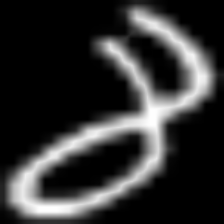

Ai pred: 2

/content/train_val/train/8/val_3500.png


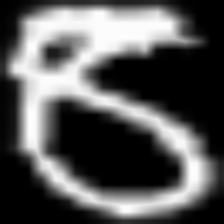

Ai pred: 5

/content/train_val/train/8/val_3501.png


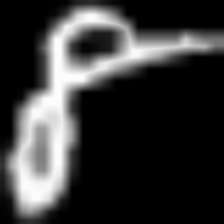

Ai pred: 5

/content/train_val/train/8/val_3532.png


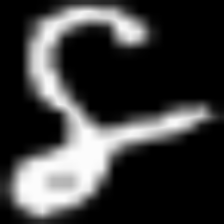

Ai pred: 2

/content/train_val/train/8/val_3553.png


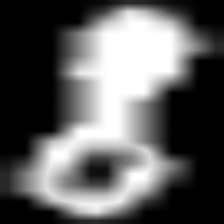

Ai pred: 1

/content/train_val/train/8/val_3564.png


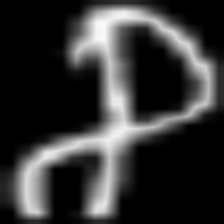

Ai pred: 2

/content/train_val/train/8/val_3645.png


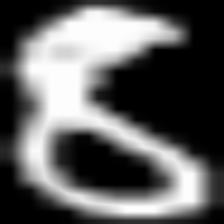

Ai pred: 6

/content/train_val/train/8/val_3668.png


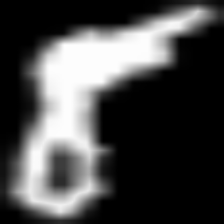

Ai pred: 5

/content/train_val/train/8/val_3672.png


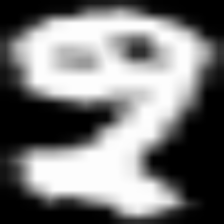

Ai pred: 9

/content/train_val/train/8/val_3695.png


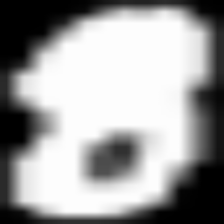

Ai pred: 1

/content/train_val/train/8/val_3759.png


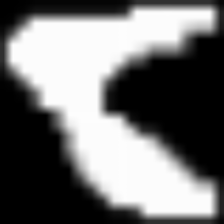

Ai pred: 5

/content/train_val/train/8/val_3785.png


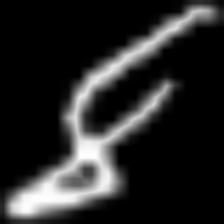

Ai pred: 6

/content/train_val/train/9/val_3796.png


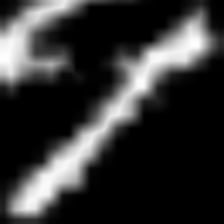

Ai pred: 1

/content/train_val/train/9/val_3830.png


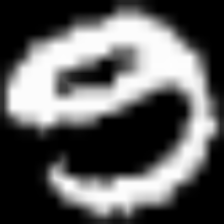

Ai pred: 5

/content/train_val/train/9/val_3842.png


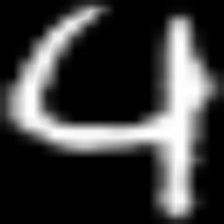

Ai pred: 4

/content/train_val/train/9/val_3875.png


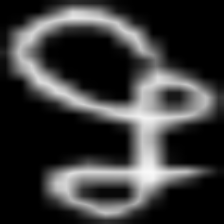

Ai pred: 8

/content/train_val/train/9/val_3901.png


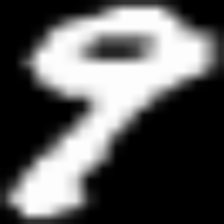

Ai pred: 8

/content/train_val/train/9/val_3945.png


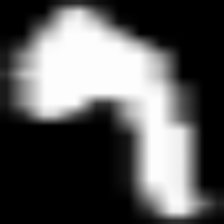

Ai pred: 1

/content/train_val/train/9/val_3988.png


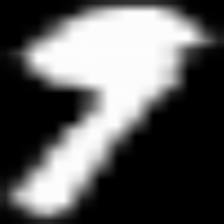

Ai pred: 7

/content/train_val/train/9/val_4029.png


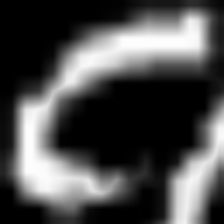

Ai pred: 5

/content/train_val/train/9/val_4031.png


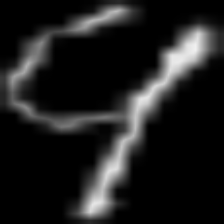

Ai pred: 7

/content/train_val/train/9/val_4077.png


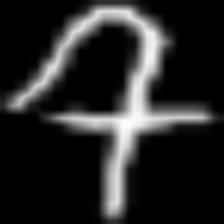

Ai pred: 7

/content/train_val/train/9/val_4087.png


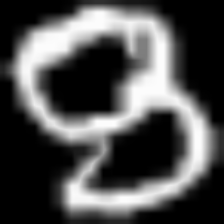

Ai pred: 8

/content/train_val/train/9/val_4138.png


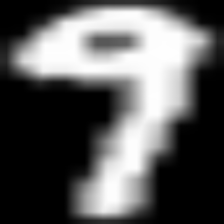

Ai pred: 7

/content/train_val/train/9/val_4154.png


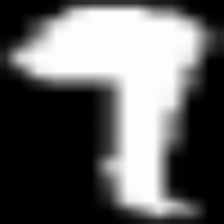

Ai pred: 7

total confuse: 83


In [ ]:
#see wrong prediction
model_best = keras.models.load_model('/content/vgg16_best')
pred = model_best.predict(validation_generator)
#predict
pred = [str(np.argmax(i)) for i in pred]

#y_true
y_true = [i[0] for i in validation_generator.filenames]

base = '/content/train_val/val' #val path
base2 = '/content/train_val/train' #train path
num = 0
for i in range(len(pred)):
  if pred[i] != y_true[i]:
    num += 1
    img = cv2.imread(f'{base}/{validation_generator.filenames[i]}')
    
    path2 = f'{os.path.join(base2, y_true[i])}/val_{i}.png'
    print(path2)
    cv2_imshow(img)
    print(f'Ai pred: {pred[i]}\n')

    # save to train img
    cv2.imwrite(path2, img)

print('total confuse:', num)

#### Train again

In [ ]:
base_dir = 'train_val'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
# train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = False)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Train Flow training images in batches of 60 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 60, class_mode = 'sparse', target_size = (224, 224))

# Validation Flow validation images in batches of 60 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 60, class_mode = 'sparse', target_size = (224, 224), shuffle=False)

# Test use flow from dataframe เพราะ เวลาส่งชื่อต้องเรียงตาม format เขา
test_generator = test_datagen.flow_from_dataframe(sub, x_col='file_name', batch_size = 60, class_mode = None , target_size = (224, 224), shuffle=False)
# test_generator = test_datagen.flow_from_dataframe(sub, x_col='file_name', y_col='ans' ,batch_size = 60, class_mode = 'sparse' , target_size = (224, 224), shuffle=False)

Found 80102 images belonging to 10 classes.
Found 4206 images belonging to 10 classes.
Found 28000 validated image filenames.


In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# Freeze the base model
base_model.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='LeakyReLU')(x)
x = layers.Dropout(0.4)(x)

# Add a final sigmoid layer with ... node for classification output
x = layers.Dense(10, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

#อย่าลืมเปลี่ยน loss ให้เหมาะกับงาน แต่คิดว่าแค่ตัวนี้ก็เพียงพอ
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#เอาไว้เก็บ best_model
!rm -rf 'vgg16_best'

checkpoint = ModelCheckpoint("vgg16_best", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='max') #2 ตัวไม่ดีขึ้นก็หยุด
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 1000, callbacks=[checkpoint,early])

Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.8545 - acc: 0.7692
Epoch 1: val_acc improved from -inf to 0.93081, saving model to vgg16_best


100/100 [==============================] - 56s 550ms/step - loss: 0.8545 - acc: 0.7692 - val_loss: 0.2238 - val_acc: 0.9308
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.2805 - acc: 0.9142
Epoch 2: val_acc did not improve from 0.93081
100/100 [==============================] - 52s 517ms/step - loss: 0.2805 - acc: 0.9142 - val_loss: 0.2140 - val_acc: 0.9301
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.1934 - acc: 0.9433
Epoch 3: val_acc improved from 0.93081 to 0.94437, saving model to vgg16_best


100/100 [==============================] - 54s 541ms/step - loss: 0.1934 - acc: 0.9433 - val_loss: 0.1802 - val_acc: 0.9444
Epoch 4/1000
100/100 [==============================] - ETA: 0s - loss: 0.1620 - acc: 0.9500
Epoch 4: val_acc improved from 0.94437 to 0.94603, saving model to vgg16_best


100/100 [==============================] - 56s 559ms/step - loss: 0.1620 - acc: 0.9500 - val_loss: 0.1718 - val_acc: 0.9460
Epoch 5/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 - acc: 0.9585
Epoch 5: val_acc improved from 0.94603 to 0.94698, saving model to vgg16_best


100/100 [==============================] - 54s 536ms/step - loss: 0.1416 - acc: 0.9585 - val_loss: 0.1839 - val_acc: 0.9470
Epoch 6/1000
100/100 [==============================] - ETA: 0s - loss: 0.1256 - acc: 0.9612
Epoch 6: val_acc improved from 0.94698 to 0.96339, saving model to vgg16_best


100/100 [==============================] - 55s 553ms/step - loss: 0.1256 - acc: 0.9612 - val_loss: 0.1169 - val_acc: 0.9634
Epoch 7/1000
100/100 [==============================] - ETA: 0s - loss: 0.1185 - acc: 0.9618
Epoch 7: val_acc improved from 0.96339 to 0.97290, saving model to vgg16_best


100/100 [==============================] - 54s 545ms/step - loss: 0.1185 - acc: 0.9618 - val_loss: 0.0899 - val_acc: 0.9729
Epoch 8/1000
100/100 [==============================] - ETA: 0s - loss: 0.1066 - acc: 0.9657
Epoch 8: val_acc improved from 0.97290 to 0.97599, saving model to vgg16_best


100/100 [==============================] - 54s 540ms/step - loss: 0.1066 - acc: 0.9657 - val_loss: 0.0819 - val_acc: 0.9760
Epoch 9/1000
100/100 [==============================] - ETA: 0s - loss: 0.1037 - acc: 0.9678
Epoch 9: val_acc did not improve from 0.97599
100/100 [==============================] - 53s 527ms/step - loss: 0.1037 - acc: 0.9678 - val_loss: 0.0838 - val_acc: 0.9743
Epoch 10/1000
100/100 [==============================] - ETA: 0s - loss: 0.1083 - acc: 0.9660
Epoch 10: val_acc improved from 0.97599 to 0.97741, saving model to vgg16_best


100/100 [==============================] - 54s 538ms/step - loss: 0.1083 - acc: 0.9660 - val_loss: 0.0743 - val_acc: 0.9774
Epoch 11/1000
100/100 [==============================] - ETA: 0s - loss: 0.1013 - acc: 0.9712
Epoch 11: val_acc did not improve from 0.97741
100/100 [==============================] - 52s 526ms/step - loss: 0.1013 - acc: 0.9712 - val_loss: 0.0841 - val_acc: 0.9750
Epoch 12/1000
100/100 [==============================] - ETA: 0s - loss: 0.0840 - acc: 0.9762
Epoch 12: val_acc improved from 0.97741 to 0.98217, saving model to vgg16_best


100/100 [==============================] - 54s 545ms/step - loss: 0.0840 - acc: 0.9762 - val_loss: 0.0568 - val_acc: 0.9822
Epoch 13/1000
100/100 [==============================] - ETA: 0s - loss: 0.0886 - acc: 0.9738
Epoch 13: val_acc did not improve from 0.98217
100/100 [==============================] - 52s 524ms/step - loss: 0.0886 - acc: 0.9738 - val_loss: 0.1202 - val_acc: 0.9624
Epoch 14/1000
100/100 [==============================] - ETA: 0s - loss: 0.0815 - acc: 0.9753
Epoch 14: val_acc did not improve from 0.98217
100/100 [==============================] - 51s 511ms/step - loss: 0.0815 - acc: 0.9753 - val_loss: 0.0588 - val_acc: 0.9817
Epoch 15/1000
100/100 [==============================] - ETA: 0s - loss: 0.0754 - acc: 0.9780
Epoch 15: val_acc did not improve from 0.98217
100/100 [==============================] - 51s 516ms/step - loss: 0.0754 - acc: 0.9780 - val_loss: 0.0639 - val_acc: 0.9807
Epoch 16/1000
100/100 [==============================] - ETA: 0s - loss: 0.0835 -

#### VGG16 finetuning 99.28% accuracy

In [ ]:
# Unfreeze the base model
base_model.trainable = True

#Everytime you Unfreeze call compile please
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='max') #5 ตัวไม่ดีขึ้นก็หยุด
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 1000, callbacks=[checkpoint,early])

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - ETA: 0s - loss: 1.3985 - acc: 0.6763
Epoch 1: val_acc did not improve from 0.98217
100/100 [==============================] - 115s 1s/step - loss: 1.3985 - acc: 0.6763 - val_loss: 0.2217 - val_acc: 0.9296
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.1810 - acc: 0.9467
Epoch 2: val_acc did not improve from 0.98217
100/100 [==============================] - 106s 1s/step - loss: 0.1810 - acc: 0.9467 - val_loss: 0.1261 - val_acc: 0.9667
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.1166 - acc: 0.9652
Epoch 3: val_acc did not improve from 0.98217
100/100 [==============================] - 106s 1s/step - loss: 0.1166 - acc: 0.9652 - val_loss: 0.1485 - val_acc: 0.9574
Epoch 4/1000
100/100 [==============================] - ETA: 0s - loss: 0.1003 - acc: 0.9705
Epoch 4: val_acc did not improve from 0.98217
100/100 [==============================] - 105s 1s/step - loss: 0.1003 - acc: 0.9705 - val_

100/100 [==============================] - 108s 1s/step - loss: 0.0657 - acc: 0.9792 - val_loss: 0.0429 - val_acc: 0.9874
Epoch 9/1000
100/100 [==============================] - ETA: 0s - loss: 0.0695 - acc: 0.9800
Epoch 9: val_acc did not improve from 0.98740
100/100 [==============================] - 105s 1s/step - loss: 0.0695 - acc: 0.9800 - val_loss: 0.0491 - val_acc: 0.9841
Epoch 10/1000
100/100 [==============================] - ETA: 0s - loss: 0.0606 - acc: 0.9835
Epoch 10: val_acc improved from 0.98740 to 0.98906, saving model to vgg16_best


100/100 [==============================] - 107s 1s/step - loss: 0.0606 - acc: 0.9835 - val_loss: 0.0404 - val_acc: 0.9891
Epoch 11/1000
100/100 [==============================] - ETA: 0s - loss: 0.0535 - acc: 0.9842
Epoch 11: val_acc did not improve from 0.98906
100/100 [==============================] - 105s 1s/step - loss: 0.0535 - acc: 0.9842 - val_loss: 0.0487 - val_acc: 0.9862
Epoch 12/1000
100/100 [==============================] - ETA: 0s - loss: 0.0584 - acc: 0.9835
Epoch 12: val_acc did not improve from 0.98906
100/100 [==============================] - 105s 1s/step - loss: 0.0584 - acc: 0.9835 - val_loss: 0.0529 - val_acc: 0.9862
Epoch 13/1000
100/100 [==============================] - ETA: 0s - loss: 0.0487 - acc: 0.9842
Epoch 13: val_acc did not improve from 0.98906
100/100 [==============================] - 104s 1s/step - loss: 0.0487 - acc: 0.9842 - val_loss: 0.0597 - val_acc: 0.9831
Epoch 14/1000
100/100 [==============================] - ETA: 0s - loss: 0.0477 - acc: 0.

In [ ]:
model_best = keras.models.load_model('/content/vgg16_best')

pred = model_best.predict(test_generator)
pred = np.argmax(pred, axis=1)

sub2 = sub[['ImageId', 'Label']].copy()
sub2['Label'] = pred
sub2.to_csv('VGG16.csv', index=False)
!kaggle competitions submit -c digit-recognizer -f 'VGG16.csv'  -m 'VGG16_val+test.csv'
# !kaggle competitions submit -c hackathon-online-2022-image-processing -f 'VGG16.csv'  -m 'VGG16.csv'

467/467 [==============================] - 141s 302ms/step
100% 208k/208k [00:02<00:00, 82.0kB/s]
Successfully submitted to Digit Recognizer

In [ ]:
!zip -r -q '/content/drive/MyDrive/Colab Notebooks/SuperAi/Pracetice/Digit Recognizer Kaggle/vgg16_best.zip' '/content/vgg16_best'

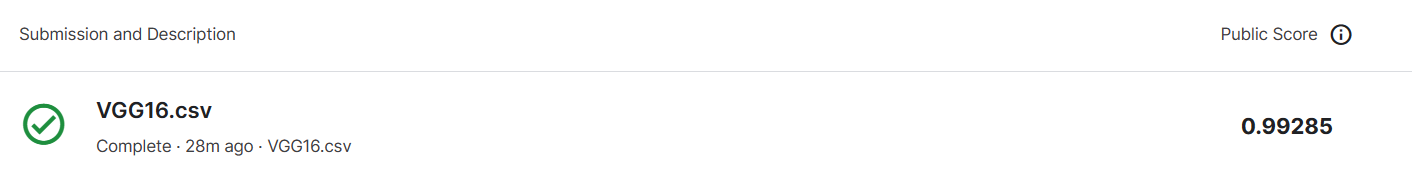